### 기본 딥러닝 구현(2층 구조)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [ ]:
class SingleLayer:    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b        # 선형 출력을 계산합니다. (364,30)(30,1)=>(364,1)+(364,1)
        return z

    def backprop(self, x, err):              #  x.shape => (364,30) , err => (364,1)
        m = len(x)                           # (30,364)(364,1)=>(30,1)
        w_grad = np.dot(x.T, err) / m         # 가중치에 대한 그래디언트를 계산합니다.
        b_grad = np.sum(err) / m              # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad                 # b 스칼라 => b_grad 스칼라

    def activation(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):  # x.shape => (364,30)
#         print(x.shape)
#         print(y.shape)
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.  y.shape (364,) => y.reshape(-1,1)
#         print(y.shape)
        
        y_val = y_val.reshape(-1, 1)
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다. w.shape => (30,1)
#         print(self.w.shape)
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
#             print(x.shape)
            z = self.forpass(x)               # 정방향 계산을 수행합니다.  x.shape => (364,30)(30,1)
#             print(z.shape)
            a = self.activation(z)            # 활성화 함수를 적용합니다.  a.shape => (364,1)
#             print(a.shape)
            err = a - y                   # 오차를 계산합니다.   y.shape => (364,1)
#             print(err.shape)
#             print(err)
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)  #  x.shape => (364,30) , err => (364,1)
#             print(w_grad.shape)
#             print(b_grad.shape)
            
            # 그래디언트에서 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [ ]:
import numpy as np
b2 = 3
temp = np.array([[1],
                 [2],
                 [3]])
print(temp.shape)
z2 = temp + b2 # (3,1) + () => (3,1) + (3,1) 
print(z2.shape)
print(z2)

err = np.array([[2],
                [2],
                [2]])
print(err.shape)
db = np.sum(err)/3
print(db.shape)
print(db)

In [ ]:
import numpy as np
b2 = 4
err = np.array([[1],
                [2],
                [3]])    # (3,1)

print(np.sum(err))
# # print(np.sum(err, axis=0))
print(err.shape)
b2_grad = np.sum(err)/3
print(b2_grad)  # 2
b2 = b2 - 0.01*b2_grad
print(b2.shape)
print(b2)

In [44]:
b2 = np.array([4,4])
temp = np.array([[1,1],
                 [2,2],
                 [3,3]])
z2 = temp + b2 # (3,2) + (2,) => (3,2) + (3,2) 
print(z2.shape)
print(z2)

(3, 2)
[[5 5]
 [6 6]
 [7 7]]


In [48]:
import numpy as np
b2 = np.array([4,4])
err = np.array([[1,1],
                [2,2],
                [3,3]])

print(err.shape)
np.sum(err, axis=0).shape
b2_grad = np.sum(err, axis=0)/3
print(b2_grad.shape)  # (2,)
print(b2_grad)
b2 = b2 - 0.01*b2_grad
print(b2.shape)
print(b2)

(3, 2)
(2,)
[2. 2.]
(2,)
[3.98 3.98]


In [49]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)               # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                    # 샘플 개수를 저장합니다.
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            a = self.training(x, y, m)
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.activation(z)    # 활성화 함수를 적용합니다.
        err = (a - y)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [50]:
dual_layer = DualLayer(units=20, l2=0.01)
dual_layer.fit(x_train_scaled, y_train, 
               x_val=x_val_scaled, y_val=y_val, epochs=12000)
dual_layer.score(x_val_scaled, y_val)

0.967032967032967

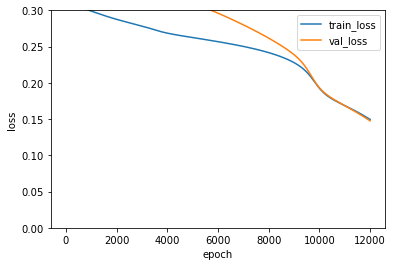

In [51]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [52]:
a = np.random.normal(0, 1,  (200,300))
# print(a)
print(np.mean(a))
print(np.std(a))

6.362326525618217e-05
1.0019695089889071


In [54]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0

In [55]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train,
                    x_val=x_val_scaled, y_val=y_val, epochs=2000)

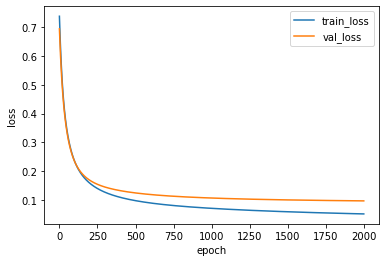

In [56]:
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

####  케라스를 이용한 다층 신경망 구현

Epoch 1/100
1/1 [==============================] - 0s 265ms/step - loss: 0.6106 - accuracy: 0.6731 - val_loss: 0.6429 - val_accuracy: 0.6154
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 0.6089 - accuracy: 0.6758 - val_loss: 0.6412 - val_accuracy: 0.6264
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 0.6073 - accuracy: 0.6758 - val_loss: 0.6395 - val_accuracy: 0.6374
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 0.6057 - accuracy: 0.6758 - val_loss: 0.6379 - val_accuracy: 0.6374
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 0.6041 - accuracy: 0.6758 - val_loss: 0.6362 - val_accuracy: 0.6374
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 0.6025 - accuracy: 0.6758 - val_loss: 0.6345 - val_accuracy: 0.6374
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 0.6010 - accuracy: 0.6758 - val_loss: 0.6329 - val_accuracy: 0.6374
Epoch 8/100
1/1 [==

1/1 [==============================] - 0s 19ms/step - loss: 0.5294 - accuracy: 0.7830 - val_loss: 0.5587 - val_accuracy: 0.7363
Epoch 60/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5282 - accuracy: 0.7830 - val_loss: 0.5575 - val_accuracy: 0.7363
Epoch 61/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5270 - accuracy: 0.7830 - val_loss: 0.5562 - val_accuracy: 0.7363
Epoch 62/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5258 - accuracy: 0.7830 - val_loss: 0.5550 - val_accuracy: 0.7473
Epoch 63/100
1/1 [==============================] - 0s 16ms/step - loss: 0.5247 - accuracy: 0.7830 - val_loss: 0.5538 - val_accuracy: 0.7582
Epoch 64/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5235 - accuracy: 0.7830 - val_loss: 0.5526 - val_accuracy: 0.7692
Epoch 65/100
1/1 [==============================] - 0s 18ms/step - loss: 0.5223 - accuracy: 0.7830 - val_loss: 0.5514 - val_accuracy: 0.7692
Epoch 66/100
1/1 [========

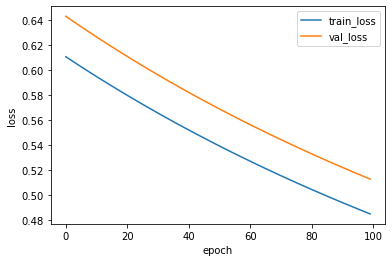

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 30)               61        
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 20)                620       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 702
Trainable params: 641
Non-trainable params: 61
_________________________________________________________________


In [58]:
from tensorflow.keras.models import Sequential # 케라스의 Sequential()을 임포트
from tensorflow.keras.layers import Dense      # 케라스의 Dense()를 임포트
from tensorflow.keras import optimizers        # 케라스의 옵티마이저를 임포트
from tensorflow.keras import regularizers

import numpy as np # Numpy를 임포트
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental import preprocessing

cancer = load_breast_cancer()

x = cancer.data
y = cancer.target

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
test_size=0.2, random_state=42)

layer = preprocessing.Normalization()
layer.adapt(x_train) # 메서드를 통해 전처리 레이어의 상태를 훈련 데이터에 노출함으로써 상태를 설정할 수 있습니다.

model=Sequential()
model.add(layer)
model.add(Dense(20, input_dim=30, activation='sigmoid'))  # (364,30)(30,20)+(20,)
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))  # (364,20)(20,1)+()
SGD=optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=SGD ,loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train,y_train, batch_size=len(x_train), epochs=100, shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

model.summary()